In [1]:
# Run this cell first to import the required modules
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mnist_loader

In [2]:
# Credit: Michael Nielsen, December 2017, "Neural Networks and Deep Learning"
# With adjustments to update code to newer version of Python and plumbing by Jeremiah Z. Griffin, May 2018

"""
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        error_rates = []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                n_correct = self.evaluate(test_data)
                accuracy_rate = n_correct / n_test
                error_rate = 1 - accuracy_rate
                error_rates.append(error_rate)
                print("Epoch {0}: {1} / {2} correct ({3:.2%} error)".format(
                    j + 1, n_correct, n_test, error_rate))
            else:
                print("Epoch {0} complete".format(j + 1))
        return error_rates

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [3]:
# Load the training, validation, and test data sets for the MNIST problem
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper('mnist.pkl.gz')
training_data, validation_data, test_data = list(training_data), list(validation_data), list(test_data)
print('Number of training samples:', len(training_data))
print('Number of validation samples:', len(validation_data))
print('Number of test samples:', len(test_data))

Number of training samples: 50000
Number of validation samples: 10000
Number of test samples: 10000


In [4]:
# Configure the network topology and training parameters
sizes = [784, 100, 50, 10] # Size of the network layers (input, hiddens, output)
epochs = 20 # Number of training iterations
mini_batch_size = 10 # Size of the training batches
eta = 0.2 # Learning rate

Before running through each epoch (including epoch 0), the entire data set is shuffled, so that the mini batches, which cut the data at different points as determined above, have different data in them for each epoch. While running through one epoch, the network runs on the first mini batch, then updates weights and biases, then moves on to the next mini batch. The process is repeated for each epoch.

The advantage of the mini batch method is that the network will perform better on each successive mini batch rather than running through the entire data set once before adjusting parameters. The network would perform poorly for the entire data set before making updates. This would also result in one large adjustment after the entire epoch versus many small adjustments after each mini batch throughout the epoch.

Outline of the algorithm:
(1) Shuffle data set of 50,000 data points
(2) Split shuffled data into mini batches of equal size
(3) Train each mini batch on the 50,000 data points
(4) Adjust weights/biases after each mini batch
(5) Once the last batch has been completed and trained, we run the 10,000 test data points through the network and output how well the network performed for the current epoch
(6) We repeat the process for the next epoch

In [5]:
# Create the network and train it on the training data set
# Run on testing data and print out error rates for each epoch
clf = Network(sizes)
error_rates = clf.SGD(training_data, epochs, mini_batch_size, eta, test_data)

Epoch 1: 7311 / 10000 correct (26.89% error)
Epoch 2: 7836 / 10000 correct (21.64% error)
Epoch 3: 8019 / 10000 correct (19.81% error)
Epoch 4: 8119 / 10000 correct (18.81% error)
Epoch 5: 8211 / 10000 correct (17.89% error)
Epoch 6: 8257 / 10000 correct (17.43% error)
Epoch 7: 8309 / 10000 correct (16.91% error)
Epoch 8: 8348 / 10000 correct (16.52% error)
Epoch 9: 8372 / 10000 correct (16.28% error)
Epoch 10: 8383 / 10000 correct (16.17% error)
Epoch 11: 8398 / 10000 correct (16.02% error)
Epoch 12: 8413 / 10000 correct (15.87% error)
Epoch 13: 8424 / 10000 correct (15.76% error)
Epoch 14: 8434 / 10000 correct (15.66% error)
Epoch 15: 8450 / 10000 correct (15.50% error)
Epoch 16: 8456 / 10000 correct (15.44% error)
Epoch 17: 8469 / 10000 correct (15.31% error)
Epoch 18: 8476 / 10000 correct (15.24% error)
Epoch 19: 8480 / 10000 correct (15.20% error)
Epoch 20: 8505 / 10000 correct (14.95% error)


Initially, the network will learn fast and then converge to some error rate. To optimize the error rate, an adaptive algorithm is needed for setting the learning rate as training progresses. With such an algorithm, the learning rate could be decreased when a local minimum is reached and the error rate stops improving for some number of epochs.

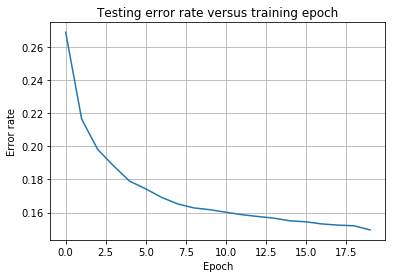

In [6]:
# Code for plotting error rate vs. training epoch
fig, ax = plt.subplots()
ax.plot(error_rates)

ax.set(xlabel='Epoch', ylabel='Error rate',
       title='Testing error rate versus training epoch')
ax.grid()
plt.show()

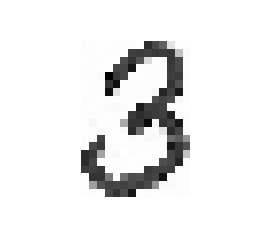

Classified as 3


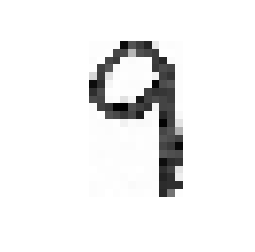

Classified as 3


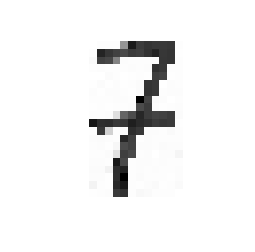

Classified as 2


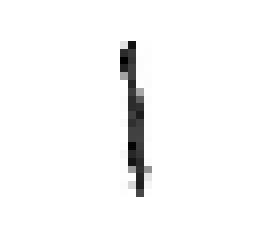

Classified as 1


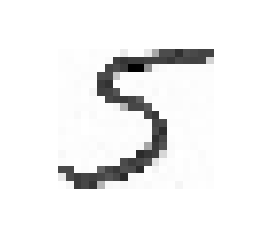

Classified as 5


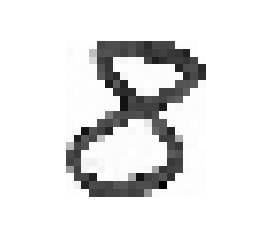

Classified as 3


In [7]:
from digit_loader import auto_digitize

files = ['scan.png']

for file in files:
    digit_ims = auto_digitize(file)
    for di in digit_ims:
        plt.axis('off')
        plt.imshow(di, cmap='gray')
        plt.show()

        x = (1 - di.flatten()).reshape((28 * 28, 1))
        y = clf.feedforward(x)
        print('Classified as', np.argmax(y))